<a href="https://colab.research.google.com/github/embarced/notebooks/blob/master/mlops/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Insurance: Predicting Crash Risk for prospective customers

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
tf.random.set_seed(42)

In [ ]:
# notebook does not need GPU, but we could turn it on any time
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import numpy as np
np.__version__

'1.19.5'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [ ]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

In [ ]:
from lrcurve import KerasLearningCurve

In [ ]:
import seaborn as sns
sns.__version__

'0.11.1'

## Loading and exploring our data set
This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved in in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [ ]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/embarced/notebooks/master/data/insurance-customers-1500.csv', sep=';')
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [ ]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [ ]:
vars = ['speed', 'age', 'miles']

In [ ]:
sns.pairplot?

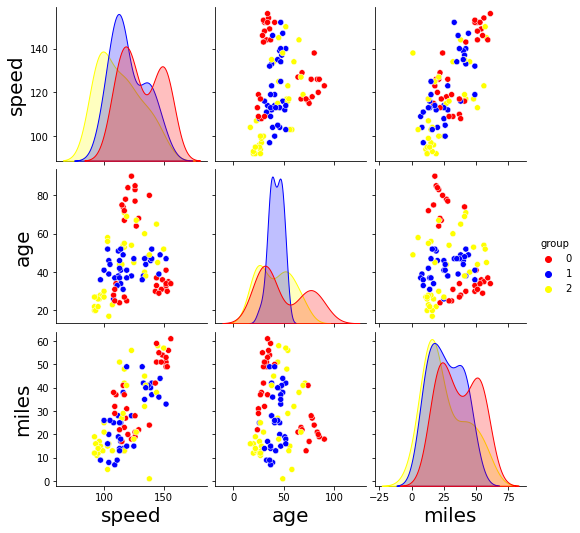

In [ ]:
sample_df = df.sample(n=100, random_state=42)
sns.pairplot(sample_df, hue="group", kind="scatter", diag_kind="kde", vars=vars, palette={0: '#FF0000', 1: '#0000FF', 2: '#FFFF00'});

In [ ]:
cm = df.corr()
cm.shape

(4, 4)

In [ ]:
cm3 = cm.iloc[:3, :3]
cm3.shape

(3, 3)

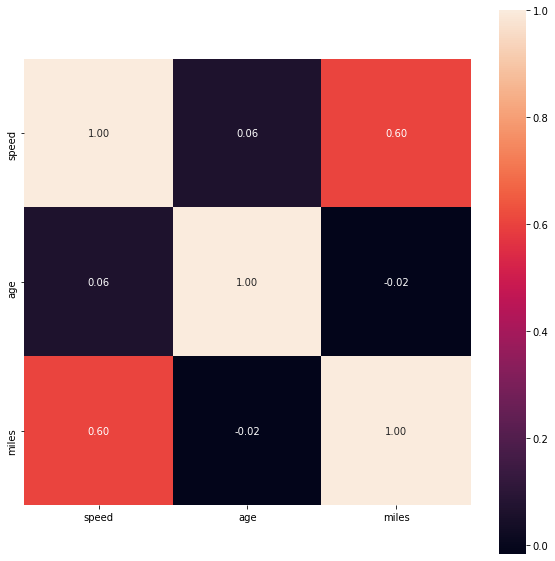

In [ ]:
plt.figure(figsize=(10, 10))
hm = sns.heatmap(cm3,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                yticklabels=vars,
                xticklabels=vars)
# plt.savefig('cm.png', transparent=True)

# Hands-On 1: Create a network and train it
  * Which features do you want to use?
  * What do you want to predict?
  * What are the first and final layer?
  * What activation function?
  * What loss?


## Hint

In [ ]:
y = df['group'].values
# add more columns to list to have fewer features to trainn on
X = df.drop(['group'], axis='columns').values
X.shape, y.shape

((1500, 3), (1500,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 3), (300, 3), (1200,), (300,))

In [ ]:
# change according to number of input features
num_features = 3
num_categories = 3

In [ ]:
from tensorflow.keras.layers import Input, Dense

model = tf.keras.Sequential()

# matches input
model.add(Input(name='input', shape=(num_features,)))

# whatever you want as hidden layer
model.add(Dense(name='hidden', units=500, activation='relu'))
model.add(Dense(name='hidden1', units=500, activation='relu'))
model.add(Dense(name='hidden2', units=500, activation='relu'))

# matches output
model.add(Dense(name='output', units=num_categories, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 500)               2000      
_________________________________________________________________
hidden1 (Dense)              (None, 500)               250500    
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
output (Dense)               (None, 3)                 1503      
Total params: 504,503
Trainable params: 504,503
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit?

In [ ]:
%%time 

# BATCH_SIZE = 32
BATCH_SIZE = 100
EPOCHS = 500

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 2min 17s, sys: 5.64 s, total: 2min 23s
Wall time: 1min 44s


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

38/38 [==============================] - 0s 3ms/step - loss: 0.4355 - accuracy: 0.8492


(0.4354969263076782, 0.8491666913032532)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

10/10 [==============================] - 0s 3ms/step - loss: 0.8667 - accuracy: 0.7267


(0.8667421340942383, 0.7266666889190674)

In [ ]:
assert model.predict(np.array([[100, 48, 10]])).argmax() == 1

In [ ]:
model.predict(np.array([[150, 30, 10]])).argmax()

0

# Hands-On 2: Regularization
  * regularize your model
  * how to make sure it generalizes?


## Hint

### An experimental approach:
- keep adding regularization to make validation and train scores come closer to each other
- this will come at the cost of train scores going down
- if both values start going down you have gone too far
- each experiment takes some time
- for larger datasets and more complex models some people start by overfitting on a subsample of the data (because it trains much faster)
  - then you can be sure you have an architecture that at least has the capacity to solve the problem
  - then keep adding regularizations
  - eventually try using the complete data
- if you want to use batch normalization place it between raw output of neuron and activation function    

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, \
                                    BatchNormalization, Activation

dropout = 0.6
model = tf.keras.Sequential()

model.add(Input(name='input', shape=(num_features,)))

# reduce capacity by decreasing number of neurons
model.add(Dense(500, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(500, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='output', units=num_categories, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               2000      
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 500)               2000      
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)              

In [ ]:
model.fit?

In [ ]:
%%time

# reducing batch size might increase overfitting, 
# but might be necessary to reduce memory requirements 
BATCH_SIZE = 32

# reduce this based on what you see in the training history
EPOCHS = 500
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    # validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 2min 45s, sys: 9.64 s, total: 2min 55s
Wall time: 2min 7s


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

38/38 [==============================] - 0s 2ms/step - loss: 0.5042 - accuracy: 0.8075


(0.5042168498039246, 0.8075000047683716)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

10/10 [==============================] - 0s 2ms/step - loss: 0.5191 - accuracy: 0.8000


(0.519097626209259, 0.800000011920929)